# Data - Learned Prediction of Space Weather
### Project Report





#### COLLABORATORS
#### 	Sukumar Hakhoo     
#### 	Agnit Mukhopadhyay [External Collaborator]

#### IDEA
The project will utilize Machine Learning to predict upper-atmospheric (ionospheric) electrical conductance in the aurora/polar regions. The auroral conductance is severely affected by space weather phenomena like solar flares and coronal mass ejections (CMEs).  This project will enable significant improvements in present predictive investigations into the physics and estimation of the auroral conductance.

#### PROBLEM
Global magnetohydrodynamic (MHD) models are used predominantly in space weather prediction. In almost all such global models, the estimation of the ionospheric conductance is conducted using outdated empirical models. This poses a massive challenge, when predicting quantities like the conductance in the aurora/polar region, which are driven mostly by electromagnetic interactions with charged particles, that MHD cannot predict accurately.

We, therefore, intend to use machine learning to predict this quantity using inputs from in-situ satellite data and ground-based instruments. This ML-based predictive model will be designed to take multiple inputs and return the conductance as an output. Once operational, the model will be installed into the University of Michigan’s Space Weather Modeling Framework (SWMF) to study improvements in space weather predictive skill.

#### METHODOLOGY
1.	Identifying the appropriate model to be used to learn on the non-linear data.
2.	Implementing the desired model in Python using a training set of specific time duration. For example, Support Vector Regression was used to train on the data. The two kernels identified to best fit the data yet, are RBF and Polynomial kernel. 
3.	Hyperparameter tuning using GridSearchCV to find the model with the least error.

#### Imports

In [10]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as scio
import os.path
import datetime as dt
import pickle
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, make_scorer

### Data Setup

#### Data Retrieval

The data for each day is present in an IDL .sav file.
This data is obtained directly from the dataset, Assimilative Mapping of Ionospheric Electrodynamics (AMIE).

In [12]:
def read_multi_files(la, lo, directory, start_time, stop_time, mode='Hall'):

    # Start Time
    t = start_time

    # Dummy Counter Variable  to count number of days
    n_days = 0

    while (t < stop_time):
            
        # Strip time into year, month and day
        t_amie = t.timetuple()

        # Increment time counter
        t = t + dt.timedelta(days=1)

        # Compute .sav file name
        if t_amie[0] > 2000:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}n.save').format(t_amie[0],
                                                                              t_amie[1],
                                                                              t_amie[2]))
        else:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}_all.save').format(t_amie[0],
                                                                                 t_amie[1],
                                                                                 t_amie[2]))

        if os.path.isfile(fname):
            n_days += 1
        else:
            print(f'WARNING: File {fname} not present in given directory.')
            
    # Read any file to find the number of coordinates present
    a = scio.readsav(fname)
    nLat = len(a['data'][:, 0])
    nMLT = len(a['data'][0, :])
    n_mins = len(a['data'][0, 0, 0])

    print(f'Number of Days: {n_days}')
    print(f'Number of Minutes: {n_mins}')
    print(f'nLatitude = {nLat}; nMLT = {nMLT}')

    # Empty Arrays to be filled by data from AMIE
    data = {}
    data['fac'] = np.zeros(n_days * n_mins)
    data['sigma_h'] = np.zeros(n_days * n_mins)
    data['sigma_p'] = np.zeros(n_days * n_mins)

    # Re-initialize Start Time
    t = start_time
    n = 0
    month = start_time.timetuple()[1]

    while (t < stop_time):
        
        # Strip time into year, month and day
        t_amie = t.timetuple()
        
        # Increment time counter
        t = t + dt.timedelta(days=1)

        # Input .sav file from Folder
        if t_amie[0] > 2000:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}n.save').format(t_amie[0],
                                                                              t_amie[1],
                                                                              t_amie[2]))
        else:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}_all.save').format(t_amie[0],
                                                                                 t_amie[1],
                                                                                 t_amie[2]))
        
        if os.path.isfile(fname):
            a = scio.readsav(fname)
                    
            # Finding indices of various features
            Fields = [i.decode("utf-8").strip() for i in a['fields']]
            for ix, x in enumerate(Fields):
                if 'pedersen conductance (aurora)' in x:
                    p = ix
                if 'hall conductance (aurora)' in x:
                    h = ix
                if 'field-aligned current' in x:
                    f = ix

            # Store data from file into the dictionary
            for t_now in range(0, n_mins):
                lat = la
                mlt = lo
                global_t = t_now + (n * n_mins)
                data['fac'][global_t] = a['data'][lat][mlt][f][t_now]
                data['sigma_h'][global_t] = a['data'][lat][mlt][h][t_now]
                data['sigma_p'][global_t] = a['data'][lat][mlt][p][t_now]
            n += 1

    f = data['fac']  # Convert 2D appended data into a single array

    if mode == 'Hall':
        h = data['sigma_h']
    elif mode == 'Pedersen':
        h = data['sigma_p']

    fac_ = ma.masked_invalid(f)
    hal_ = ma.masked_invalid(h)
    fac = np.array([fac_]).T
    hal = np.array(hal_)

    X = fac
    y = hal
    X_ = np.array([i[0] for i in X])

    X_y = np.vstack((X_, y)).T
    X_y_sorted = X_y[X_y[:, 0].argsort()]

    X_1_2D = np.array([X_y_sorted.T[0]]).T
    y_1 = X_y_sorted.T[1]

    return X_1_2D, y_1

In [13]:
def read_dataset(directory, start_time, stop_time):

    print('Reading data files.')

    # Track number of days of data
    n_days = 0

    # Checking whether all files exist from start time to stop time.
    t = start_time

    while (t < stop_time):

        # Strip time into year, month and day
        t_amie = t.timetuple()

        # Increment time counter
        t = t + dt.timedelta(days=1)

        # Compute .sav file name
        if t_amie[0] > 2000:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}n.save').format(t_amie[0],
                                                                              t_amie[1],
                                                                              t_amie[2]))
        else:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}_all.save').format(t_amie[0],
                                                                                 t_amie[1],
                                                                                 t_amie[2]))

        if os.path.isfile(fname):
            n_days += 1
        else:
            print(f'WARNING: File {fname} not present in given directory.')

    # Read any file to find the number of coordinates present
    a = scio.readsav(fname)
    nLat = len(a['data'][:, 0])
    nMLT = len(a['data'][0, :])
    n_mins = len(a['data'][0, 0, 0])

    print(f'Number of Days: {n_days}')
    print(f'Number of Minutes: {n_mins}')
    print(f'nLatitude = {nLat}; nMLT = {nMLT}')

    # Empty dataset to be filled by data from AMIE
    # Columns
    # Labels: sigma_h, sigma_p
    # Features: fac, lat, mlt
    dataset = np.zeros((n_days * n_mins * nLat * nMLT, 5))
    
    # Re-initialize Start Time
    t = start_time
    n = 0

    row_num = -1

    while t < stop_time:
        
        # Strip time into year, month and day
        t_amie = t.timetuple()
        
        # Increment time counter
        t = t + dt.timedelta(days=1)

        # Input .sav file from Folder
        if t_amie[0] > 2000:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}n.save').format(t_amie[0],
                                                                              t_amie[1],
                                                                              t_amie[2]))
        else:
            fname = ((directory +
                      '{0:4d}/{1:0=2d}/b{0:4d}{1:0=2d}{2:0=2d}_all.save').format(t_amie[0],
                                                                                 t_amie[1],
                                                                                 t_amie[2]))
        print(f'Reading file {fname}')
        if os.path.isfile(fname):
            a = scio.readsav(fname)  # Read file

            # Finding indices of various features
            Fields = [i.decode("utf-8").strip() for i in a['fields']]
            for ix, x in enumerate(Fields):
                if 'pedersen conductance (aurora)' in x:
                    p = ix
                if 'hall conductance (aurora)' in x:
                    h = ix
                if 'field-aligned current' in x:
                    f = ix

            # Columns
            # Labels: sigma_h, sigma_p
            # Features: fac, lat, mlt
            for t_now in range(0, n_mins):
                for lat in range(nLat):
                    for mlt in range(nMLT):
                        row_num += 1
                        dataset[row_num] = [a['data'][lat][mlt][h][t_now],
                                            a['data'][lat][mlt][p][t_now],
                                            a['data'][lat][mlt][f][t_now],
                                            a['lats'][lat],
                                            a['mlts'][mlt]]


    data_sorted = dataset[dataset[:, 2].argsort()]
    print('Data read complete.')
    return data_sorted

In [14]:
# Read data file of 01/01/2003
directory = 'Data/'

start_time = dt.datetime(2003, 1, 1, 0, 0, 0)
stop_time = dt.datetime(2003, 1, 2, 0, 0, 0)

data_ = read_dataset(directory, start_time, stop_time)

print('Shape of dataset of one day = ' + str(data_.shape))

Reading data files.
Number of Days: 1
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Reading file Data/2003/01/b20030101n.save
Data read complete.
Shape of dataset of one day = (864000, 5)


In [15]:
dataset_ = pd.DataFrame(data_, columns=['Hall Conductance (Aurora)', 
                                       'Pedersen Conductance (Aurora)', 
                                       'Field-aligned current', 
                                       'lat',
                                       'mlt'])
dataset_.head()

,Hall Conductance (Aurora),Pedersen Conductance (Aurora),Field-aligned current,lat,mlt
0,8.715409,7.134633,-0.495655,70.0,5.0
1,8.798059,7.193340,-0.492012,70.0,5.0
2,8.803224,7.128635,-0.458422,70.0,5.0
3,8.550262,7.010095,-0.455883,70.0,5.0
4,8.810525,7.148898,-0.452674,70.0,5.0


#### Data Processing

The data in the raw dataset is present as a multi-dimensional array. Each dimension denotes a particular feautre or label.

Hence, the data is processed by flattening the raw data into a 2-dimensional array which has two labels in the beginning followed by three features.

The processing of the data is done as a part of the retrieval in the function $read\_dataset$. 

We first define functions that help us save and read data, to and from pickle files. 

These functions will be used to save the processed data so that it can be retrieved directly when trying to train a model or test it.

In [16]:
def save_data(file_name, data):
    with open(file_name, "wb") as fp:
        pickle.dump(data, fp)
        print('Data saved.')


def read_data(file_name):
    if os.path.isfile(file_name):
        with open(file_name, "rb") as fp:
            data = pickle.load(fp)
            return data, True
    else:
        print('Data\'s pickle file not found')
        return [], False

In [17]:
def process_data(in_directory, out_directory, start_time, stop_time):

    print('Processing data files.')
    data = read_dataset(in_directory, start_time, stop_time)
    save_data(out_directory, data)

In [18]:
# Cataloging training and testing scenarios

Trainings = ['01_01_to_02_01.p', '01_01_to_10_01.p',
             '01_01_to_30_01.p', '01_01_to_10_01.p']

In [19]:
# Processing training data
input_directory = 'Data/'
processed_data_filename = 'Processed_Data/2003/01_01_to_10_01.p'

start_time = dt.datetime(2003, 1, 1, 0, 0, 0)
stop_time = dt.datetime(2003, 1, 10, 0, 0, 0)

process_data(input_directory, processed_data_filename,
             start_time, stop_time)

Processing data files.
Reading data files.
Number of Days: 9
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Reading file Data/2003/01/b20030101n.save
Reading file Data/2003/01/b20030102n.save
Reading file Data/2003/01/b20030103n.save
Reading file Data/2003/01/b20030104n.save
Reading file Data/2003/01/b20030105n.save
Reading file Data/2003/01/b20030106n.save
Reading file Data/2003/01/b20030107n.save
Reading file Data/2003/01/b20030108n.save
Reading file Data/2003/01/b20030109n.save
Data read complete.
Data saved.


We use data from one year for training and from another year for testing.

Since the raw data is present in the same structure, the test data can be processed similarly.

In [43]:
# Processing testing data
start_time = dt.datetime(2004, 1, 1, 0, 0, 0)
stop_time = dt.datetime(2004, 1, 10, 0, 0, 0)

processed_data_filename = 'Processed_Data/2004/01_01_to_10_01.p'

process_data(input_directory, processed_data_filename,
             start_time, stop_time)

Processing data files.
Reading data files.
Number of Days: 9
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Reading file Data/2004/01/b20040101n.save
Reading file Data/2004/01/b20040102n.save
Reading file Data/2004/01/b20040103n.save
Reading file Data/2004/01/b20040104n.save
Reading file Data/2004/01/b20040105n.save
Reading file Data/2004/01/b20040106n.save
Reading file Data/2004/01/b20040107n.save
Reading file Data/2004/01/b20040108n.save
Reading file Data/2004/01/b20040109n.save
Data read complete.
Data saved.


#### Splitting the dataset

The data visualization suggests a considerable difference between a possible model that could fit all the data with $x > 0$ and $x < 0$. Hence, classifying the data into two classes, one with input $x > 0$ and the other with $x < 0$ and training separate models on each might help increase the accuracy of the entire model while not impacting its ability to generalize on new data.

We thus consider two cases.
1.	The entire dataset used for training together.
2.	The dataset being split on the basis of a particular feature based on the visualization of the data.

The inspiration for this method comes from how Decision Trees work.

In [20]:
def split_pos_and_neg_set(X, y):
    positive_indices = [i for i, val in enumerate(X >= 0) if val]
    negative_indices = [i for i, val in enumerate(X < 0) if val]

    X_pos = np.array([X[i] for i in positive_indices])
    y_pos = np.array([y[i] for i in positive_indices])

    X_neg = np.array([X[i] for i in negative_indices])
    y_neg = np.array([y[i] for i in negative_indices])

    return X_pos, X_neg, y_pos, y_neg

#### Plotting functions

The following functions are defined to plot the output from the Support Vector Regressions. 

The first two functions have an additional parameter of 'mode'. This is used to separate the training plots from the test plots.

The scatter functons are modified to show which data samples are used as support vectors and which samples are not. Additionally, it also scatters the training labels so that the model fitting on the data can be visualized.

Firstly, the $plot\_svr$ function plots the predicted value against the training feature for a single trained SVR model.

In [21]:
def plot_svr(X, y_hat, y, svr, kernel_label,
             model_color, dataset_color,
             mode='train'):

    plt.plot(X, y_hat,
             color=model_color,
             label=f'{kernel_label} model')

    if mode == 'train':
        plt.scatter(X[svr.support_], y[svr.support_], facecolor="none",
                    edgecolor=dataset_color, s=50,
                    label=f'{kernel_label} model')
        plt.scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                    y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                    facecolor="none", edgecolor="k", s=50,
                    label='other training data')

    elif mode == 'test':
        plt.scatter(X, y, facecolor="none",
                    edgecolor=dataset_color, s=50,
                    label=f'Data')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=1, fancybox=True, shadow=True)
    # plt.axis([min(X) - 0.1, max(X) + 0.1, min(y) - 1, max(y) + 1], 'equal')
    plt.suptitle("Support Vector Regression", fontsize=14)
    plt.show()

Secondly, the $plot\_svr\_combined$ function plots the predicted value against the training feature for a trained SVR model in which the dataset is split.

In [22]:
def plot_svr_combined(X, y_hat, y, kernel_label, model_color, dataset_color, svrs,
                      n_rows=1, n_cols=2, fig_size=(10, 5),
                      mode='train'):
    lw = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size, sharey=True)

    for ix, svr in enumerate(svrs):
        axes[ix].plot(X[ix], y_hat[ix], color=model_color[ix], lw=lw,
                      label=f'{kernel_label[ix]} model')

        if mode == 'train':
            axes[ix].scatter(X[ix][svr.support_], y[ix][svr.support_], facecolor="none",
                             edgecolor=dataset_color[ix], s=50,
                             label=f'{kernel_label[ix]} support vectors')
            axes[ix].scatter(X[ix][np.setdiff1d(np.arange(len(X[ix])), svr.support_)],
                             y[ix][np.setdiff1d(np.arange(len(X[ix])), svr.support_)],
                             facecolor="none", edgecolor="k", s=50,
                             label='other training data')

        elif mode == 'test':
            axes[ix].scatter(X[ix], y[ix], facecolor="none",
                             edgecolor=dataset_color[ix], s=50,
                             label=f'Data')

        axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=True, shadow=True)

#         if ix == 0:
#             axes[ix].axis([min(X[ix]) - 0.1, max(X[ix]), min(y[ix]) - 1, max(y[ix]) + 1], 'equal')
#         else:
#             axes[ix].axis([min(X[ix]), max(X[ix]) + 0.1, min(y[ix]) - 1, max(y[ix]) + 1], 'equal')

    fig.text(0.5, 0.04, 'data', ha='center', va='center')
    fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
    fig.suptitle("Support Vector Regression", fontsize=14)
    plt.show()

Secondly, the $plot\_multiple\_svr$ function plots the predicted value against the training feature for different trained SVR models in order to validate different trained models together.

In [23]:
def plot_multiple_svr(X, y, kernel_label, model_color, svrs, n_rows=1, n_cols=2, fig_size=(10, 5)):
    lw = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size, sharey=True)
    for ix, svr in enumerate(svrs):
        axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                      label=f'{kernel_label[ix]} model')
        axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                         edgecolor=model_color[ix], s=50,
                         label=f'{kernel_label[ix]} support vectors')
        axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                         y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                         facecolor="none", edgecolor="k", s=50,
                         label='other training data')
        axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=True, shadow=True)
    fig.text(0.5, 0.04, 'data', ha='center', va='center')
    fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
    fig.suptitle("Support Vector Regression", fontsize=14)
    plt.show()

#### Parameter Tuning

The Hyper-Parameters can be tuned using GridSearchCV.

In [24]:
def Hyper_parameter_tuning(X, y, model_estimator, configs):
    n_train = len(X)
    validation_fold_ = [-1] * ((int)(0.8 * n_train)) + [0] * ((int)(0.2 * n_train))
    validation_fold = np.random.permutation(validation_fold_)

    # Using GridSearchCV to tune the hyper-parameters
    ps = PredefinedSplit(validation_fold)
    clf = GridSearchCV(model_estimator,
                       configs,
                       return_train_score=True,
                       cv=ps,
                       refit=True,
                       n_jobs=-1,
                       scoring=make_scorer(mean_squared_error, greater_is_better=False))
    clf.fit(X, y)
    return clf

#### Model Training

The model is trained using Support Vector Regression. This is done using the SVR implementation in the Scikit-Learn library.

We examine four scenarios.
1.	Training using the single feature, FAC, and then testing the output.
2.	Training using the single feature, FAC, on splitted dataset and then testing the output.
3.	Training using the mutiple features, FAC, lat and mlt, and then testing the output.
4.	Training using the mutiple features, FAC, lat and mlt, on splitted dataset and then testing the output.

The trained models can be saved into pickle files so that when testing is required on newer data the trained models can be quickly retrieved and re-training is not required.

##### Single Feature

We first train the model using the feature FAC and tune the hyper parameters using the function defined above.

In [25]:
def Non_Linear_Reg_SVR_Tuned(X, y, configs):

    print('Tuning Hyper-parameters.')
    svr_estimator = SVR(coef0=1)

    clf = Hyper_parameter_tuning(X, y, svr_estimator, configs)

    print('Hyper-parameter tuning completed')
    print(f'Best parameters are: {clf.best_params_}')
    print(f'Best score is: {clf.best_score_}')

    kernel_label = clf.best_params_['kernel']

    svr = SVR(kernel=clf.best_params_['kernel'],
              C=clf.best_params_['C'],
              gamma=clf.best_params_['gamma'],
              epsilon=clf.best_params_['epsilon'],
              degree=clf.best_params_['degree'], coef0=1)

    y_hat = svr.fit(X, y).predict(X)

    plot_svr(X, y_hat, y, svr, kernel_label, 'm', 'r', mode='train')

    return clf, svr

In [26]:
def single_svr(X, y):
    svr = SVR(kernel='rbf', C=6, gamma=12, epsilon=.01, degree=7)
    y_hat = svr.fit(X, y).predict(X)
    plot_svr(X, y_hat, y, 'SVR', 'm', 'r', svr)
    print('Training complete')

In [31]:
# Read data file
print("Reading the training data files.")

start_time = dt.datetime(2003, 1, 1, 0, 0, 0)  # Start Time
stop_time = dt.datetime(2003, 1, 10, 0, 0, 0)  # Stop Time

directory = 'Data/'

X_train, y_train = read_multi_files(16, 0,
                                    directory,
                                    start_time,
                                    stop_time,
                                    mode='Hall')

print('Data read complete.')

Reading the training data files - 01/2003
Number of Days: 9
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Data read complete.


Tuning Hyper-parameters.
Hyper-parameter tuning completed
Best parameters are: {'C': 20, 'degree': 4, 'epsilon': 0.2, 'gamma': 20, 'kernel': 'rbf'}
Best score is: -2.3199609255360945


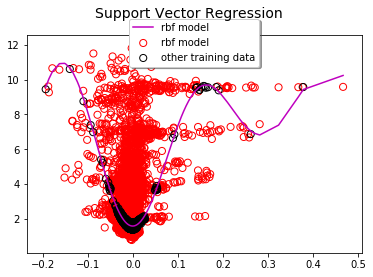

In [39]:
# Hyper-parameter tuning configuration
SVR_configs = [{'kernel': ['poly', 'rbf'],
                'gamma': [20, 15, 10, 0.1],
                'C': [20, 15, 10, 1, 0.1],
                'epsilon': [0.2, 0.1, 0.05],
                'degree': [4, 5, 6]}]

clf, svr = Non_Linear_Reg_SVR_Tuned(X_train,
                                    y_train,
                                    SVR_configs)

##### Saving the model

In [40]:
save_data('Trained_Models/svr_1_month.p', 
          ['Non_Linear_Reg_SVR_Tuned', [clf, svr]])

Data saved.


Next, we train two models on a splitted dataset and store the best configurations and trained models for both positive and negative values in feature of the training set.

In [41]:
def Non_Linear_Reg_SVR_Tuned_Splitted_Dataset(X, y, configs):

    X_pos, X_neg, y_pos, y_neg = split_pos_and_neg_set(X, y)

    svr_estimator = SVR(coef0=1)
    clf_pos = Hyper_parameter_tuning(X_pos, y_pos, svr_estimator, configs)
    clf_neg = Hyper_parameter_tuning(X_neg, y_neg, svr_estimator, configs)

    best_pos_params = clf_pos.best_params_
    best_neg_params = clf_neg.best_params_

    print(f'Best parameters for positives are: {best_pos_params}')
    print(f'Best score for positives are: {clf_pos.best_score_}')
    print(f'Best parameters for negatives are: {best_neg_params}')
    print(f'Best score for negatives are: {clf_neg.best_score_}')

    kernel_label = [best_neg_params['kernel'], best_pos_params['kernel']]
    model_color = ['m', 'g']
    dataset_color = ['b', 'b']

    svr_pos_best = SVR(kernel=best_pos_params['kernel'],
                       C=best_pos_params['C'],
                       gamma=best_pos_params['gamma'],
                       epsilon=best_pos_params['epsilon'],
                       degree=best_pos_params['degree'], coef0=1)
    svr_neg_best = SVR(kernel=best_neg_params['kernel'],
                       C=best_neg_params['C'],
                       gamma=best_neg_params['gamma'],
                       epsilon=best_neg_params['epsilon'],
                       degree=best_neg_params['degree'], coef0=1)

    y_hat_pos = svr_pos_best.fit(X_pos, y_pos).predict(X_pos)
    y_hat_neg = svr_neg_best.fit(X_neg, y_neg).predict(X_neg)

    plot_svr_combined([X_neg, X_pos], [y_hat_neg, y_hat_pos], [y_neg, y_pos],
                      kernel_label, model_color, dataset_color,
                      [svr_neg_best, svr_pos_best],
                      mode='train')

    return clf_neg, clf_pos, svr_pos_best, svr_neg_best

Best parameters for positives are: {'C': 20, 'degree': 6, 'epsilon': 0.2, 'gamma': 20, 'kernel': 'poly'}
Best score for positives are: -2.7278385696946783
Best parameters for negatives are: {'C': 20, 'degree': 4, 'epsilon': 0.2, 'gamma': 20, 'kernel': 'rbf'}
Best score for negatives are: -1.7012251844765613


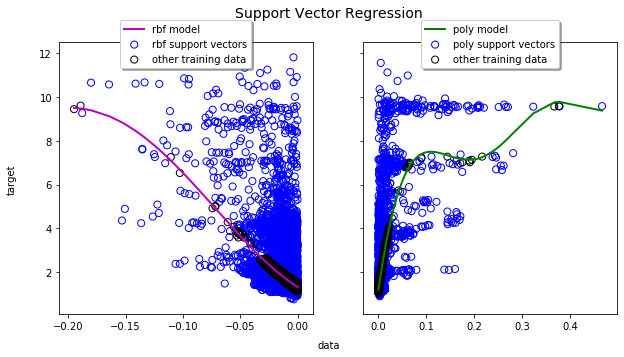

In [42]:
# Hyper-parameter tuning configuration
SVR_configs = [{'kernel': ['poly', 'rbf'],
                'gamma': [20, 15, 10, 0.1],
                'C': [20, 15, 10, 1, 0.1],
                'epsilon': [0.2, 0.1, 0.05, 0.01],
                'degree': [4, 5, 6]}]

clf_neg, clf_pos, svr_pos_best, svr_neg_best = Non_Linear_Reg_SVR_Tuned_Splitted_Dataset(X_train,
                                                                                         y_train,
                                                                                         SVR_configs)

We now have the best configurations for both the cases and we use these configurations when training on multiple features.

##### Saving the model

In [46]:
save_data('Trained_Models/svr_1_month_splitted_dataset.p', 
          ['Non_Linear_Reg_SVR_Tuned_Splitted_Dataset',
           [clf_neg, clf_pos, svr_pos_best, svr_neg_best]])

Data saved.


##### Multi-Feature

We, now, train the model using the multiple features. The configuration for training is taken from the above trained model so we don't have to tune the hyper parameters on the large dataset.

When we consider three features the size of our dataset increases vastly. This is because instead of considering the FAC for one particular lat and mlt, we now consider all the values of FAC along with lat and mlt.

In [52]:
def svr_config(X, y, params):
    # svr = SVR(kernel='rbf', C=6, gamma=12, epsilon=.1, degree=5)
    svr = SVR(**params)
    svr_model = svr.fit(X, y)
    y_hat = svr_model.predict(X)
    print('Training complete')
    save_data('Trained_Models/svr_multi_feature_2.p', ['single_svr', svr_model])
    print('Model saved.')
    return svr_model

In [53]:
# Read data file
print("Reading the training data files")

directory = 'Data/'
filename = 'Processed_Data/2003/01_01_to_01_02.p'

dataset_train, is_success = read_data(filename)

y_train = dataset_train[:, 0].T

X_train = dataset_train[:, 2:]

Reading the training data files


In [ ]:
print('Training model.')

# Hyper-parameter tuned configuration
parameters = {'kernel': clf.best_params_['kernel'],
              'gamma': clf.best_params_['gamma'],
              'C': clf.best_params_['C'],
              'epsilon': clf.best_params_['epsilon'],
              'degree': clf.best_params_['degree']}

svr_multi = svr_config(X_train, y_train, parameters)

Training model.


We also train the multi-feature model using splitted dataset.

In [ ]:
def svr_splitted_config(X, y, params):

    X_pos, X_neg, y_pos, y_neg = split_pos_and_neg_set(X, y)

    

    kernel_label = [best_neg_params['kernel'], best_pos_params['kernel']]
    model_color = ['m', 'g']
    dataset_color = ['b', 'b']

    svr_pos_best = SVR(**params['pos'])
    svr_neg_best = SVR(**params['neg'])

    y_hat_pos = svr_pos_best.fit(X_pos, y_pos).predict(X_pos)
    y_hat_neg = svr_neg_best.fit(X_neg, y_neg).predict(X_neg)

    print('Training complete')
    save_data('Trained_Models/svr_multi_feature_split_1.p', ['svr_split', [svr_pos_best, svr_neg_best]])
    print('Model saved.')
    return svr_neg_best, svr_pos_best

In [ ]:
print('Training model.')

# Hyper-parameter tuned configuration
parameters = {'pos': {'kernel': clf_pos.best_params_['kernel'],
                      'gamma': clf_pos.best_params_['gamma'],
                      'C': clf_pos.best_params_['C'],
                      'epsilon': clf_pos.best_params_['epsilon'],
                      'degree': clf_pos.best_params_['degree'], 
                      'coef0':1},
              'neg': {'kernel': clf_neg.best_params_['kernel'],
                      'gamma': clf_neg.best_params_['gamma'],
                      'C': clf_neg.best_params_['C'],
                      'epsilon': clf_neg.best_params_['epsilon'],
                      'degree': clf_neg.best_params_['degree'], 
                      'coef0':1}}

svr_multi_neg, svr_multi_pos = svr_splitted_config(X_train, y_train, parameters)

#### Model Testing

The model is then tested.

##### Testing Single Feature Model

In [47]:
def Testing_Model_single_feature(X_test, y_test, model_file_name):
    data, is_read_successful = read_data(model_file_name)
    if is_read_successful:

        print('Model retrieved')

        if data[0] == 'Non_Linear_Reg_SVR_Tuned':
            [clf, svr] = data[1]
            y_hat = svr.predict(X_test)
            test_score = svr.score(X_test, y_test)
            print(f'Test Score = {test_score}')
            plot_svr(X_test, y_hat, y_test, svr, svr.kernel, 'm', 'b', mode='test')

        elif data[0] == 'Non_Linear_Reg_SVR_Tuned_Splitted_Dataset':
            [clf_neg, clf_pos, svr_pos, svr_neg] = data[1]
            X_test_pos, X_test_neg, y_test_pos, y_test_neg = split_pos_and_neg_set(X_test, 
                                                                                   y_test)

            y_hat_neg = svr_neg.predict(X_test_neg)
            y_hat_pos = svr_pos.predict(X_test_pos)

            test_score_neg = svr_neg.score(X_test_neg, y_test_neg)
            test_score_pos = svr_pos.score(X_test_pos, y_test_pos)

            print(f'Positive Test Score = {test_score_pos}')
            print(f'Negative Test Score = {test_score_neg}')

            plot_svr_combined([X_test_neg, X_test_pos], [y_hat_neg, y_hat_pos], 
                              [y_test_neg, y_test_pos], [svr_neg.kernel, svr_pos.kernel], 
                              ['m', 'g'], ['b', 'b'], 
                              [svr_neg, svr_pos], mode='test')

Testing Single Feature Model
Number of Days: 9
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Model retrieved
Test Score = -0.27134783851557187


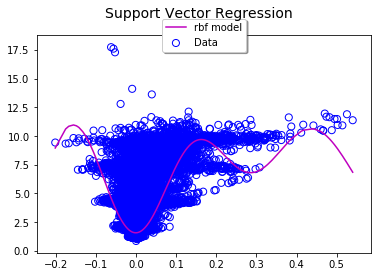

Model retrieved
Positive Test Score = 0.2715650943666844
Negative Test Score = -0.5195736687925274


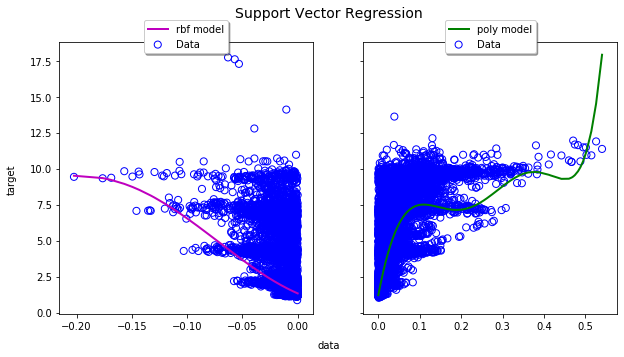

In [51]:
print('Testing Single Feature Model')

start_time_test = dt.datetime(2004, 1, 1, 0, 0, 0)
stop_time_test = dt.datetime(2004, 1, 10, 0, 0, 0)

directory = 'Data/'

X_test, y_test = read_multi_files(16, 0,
                                  directory,
                                  start_time_test,
                                  stop_time_test,
                                  mode='Hall')

model_file_name = 'Trained_Models/svr_1_month.p'

Testing_Model_single_feature(X_test, y_test, model_file_name)

model_file_name_2 = 'Trained_Models/svr_1_month_splitted_dataset.p'

Testing_Model_single_feature(X_test, y_test, model_file_name_2)

##### Testing Multi Feature Model

In [96]:
def Testing_Model_multi_feature(test_dataset, model_file_name):
    data, is_read_successful = read_data(model_file_name)
    y_test = test_dataset[:, 0].T
    X_test = test_dataset[:, 2:]

    if is_read_successful:

        print('Model retrieved')
        if data[0] == 'single_svr':
            svr_model = data[1]
            y_hat = svr_model.predict(X_test)
            test_score = svr_model.score(X_test, y_test)
            print(f'Test Score = {test_score}')
            return test_score
        
        elif data[0] == 'svr_split':
            [svr_pos, svr_neg] = data[1]
            X_test_pos, X_test_neg, y_test_pos, y_test_neg = split_pos_and_neg_set(X_test, 
                                                                                   y_test)

            y_hat_neg = svr_neg.predict(X_test_neg)
            y_hat_pos = svr_pos.predict(X_test_pos)

            test_score_neg = svr_neg.score(X_test_neg, y_test_neg)
            test_score_pos = svr_pos.score(X_test_pos, y_test_pos)

            print(f'Positive Test Score = {test_score_pos}')
            print(f'Negative Test Score = {test_score_neg}')

In [95]:
print('Testing Multi Feature Model')

start_time_test = dt.datetime(2004, 1, 1, 0, 0, 0)
stop_time_test = dt.datetime(2004, 1, 10, 0, 0, 0)

test_data_filename = 'Processed_Data/2004/01_01_to_10_01.p'

test_dataset, is_success = read_data(test_data_filename)

model_file_name = 'Trained_Models/svr_multi_feature_1.p'

test_score = Testing_Model_multi_feature(test_dataset, model_file_name)

Testing Multi Feature Model
Model retrieved
Test Score = -1.5645337354046052
